<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# ARIMA: Autoregressive Integrated Moving Average

This notebook provides an example of how to train an ARIMA model to generate point forecasts of product sales in retail. We will train an ARIMA based model on the Orange Juice dataset.

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using an `ARIMA(p,d,q)` model within `statsmodels` library. In this notebook, we will be using an alternative library `pmdarima`, which allows us to automatically search for optimal ARIMA parameters, within a specified range. More specifically, we will be using `auto_arima` function within `pmdarima` to automatically discover the optimal parameters for an ARIMA model. This function wraps `ARIMA` and `SARIMAX` models of `statsmodels` library, that correspond to non-seasonal and seasonal model space, respectively.

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:
- **p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
- **d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- **q** is the parameter associated with the moving average part of the model.,

If our data has a seasonal component, we use a seasonal ARIMA model or `ARIMA(p,d,q)(P,D,Q)m`. In that case, we have an additional set of parameters: `P`, `D`, and `Q` which describe the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model, and `m` refers to the number of periods in each season.

We provide a [quick-start ARIMA example](https://github.com/microsoft/forecasting/blob/master/examples/grocery_sales/python/00_quick_start/autoarima_single_round.ipynb), in which we explain the process of using ARIMA model to forecast a single time series, and analyze the model performance. Please take a look at this notebook for more information.

In this notebook, we will train an ARIMA model on multiple splits (round) of the train/test data.

## Global Settings and Imports

In [1]:
import os
import sys
import math
import warnings
import itertools
import numpy as np
import pandas as pd
from datetime import datetime

from pmdarima.arima import auto_arima

from fclib.common.utils import module_exists
from fclib.common.plot import plot_predictions_with_history
from fclib.evaluation.evaluation_utils import MAPE
from fclib.dataset.ojdata import split_train_test, complete_and_fill_df

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))

System version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


## Parameters

Next, we define global settings related to the model. We will use historical weekly sales data only, without any covariate features to train the ARIMA model. The model parameter ranges are provided in params. These are later used by the `auto_arima()` function to search the space for the optimal set of parameters. To increase the space of models to search over, increase the `max_p` and `max_q` parameters.

> NOTE: Our data does not show a strong seasonal component (as demonstrated in data exploration example notebook), so we will not be searching over the seasonal ARIMA models. To search over the seasonal models, set `seasonal` to `True` and include `start_P`, `start_Q`, `max_P`, and `max_Q` parameters in the auto_arima() function.

In [2]:
# Data directory
DATA_DIR = os.path.join("ojdata")

# Forecasting settings
N_SPLITS = 5
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

# Parameters of ARIMA model
params = {
    "seasonal": False,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
}


# Run notebook on a subset of stores (to reduce the run time)
STORE_SUBSET = True

## Data Preparation

We need to download the Orange Juice data and split it into training and test sets. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by switching `DOWNLOAD_SPLIT_DATA` to `False`.

We store the training data and test data using dataframes. The training data includes `train_df` and `aux_df` with `train_df` containing the historical sales up to week 135 (the time we make forecasts) and `aux_df` containing price/promotion information up until week 138. Here we assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. In our example, we will be using historical sales only, and will not be using the `aux_df` data. The test data is stored in `test_df` which contains the sales of each product in week 137 and 138. Assuming the current week is week 135, our goal is to forecast the sales in week 137 and 138 using the training data. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

The setting of the forecast problem are defined in `fclib.dataset.ojdata.split_train_test` function. We can change this setting (e.g., modify the horizon of the forecast or the range of the historical data) by passing different parameters to this functions. Below, we split the data into `n_splits=N_SPLITS` splits, using the forecasting settings listed above in the *Parameters* section.

In [3]:
train_df_list, test_df_list, _ = split_train_test(
    DATA_DIR,
    n_splits=N_SPLITS,
    horizon=HORIZON,
    gap=GAP,
    first_week=FIRST_WEEK,
    last_week=LAST_WEEK,
    write_csv=True,
)

To create training data and test data for multi-round forecasting, we pass a number greater than `1` to `n_splits` parameter in `split_train_test()` function. Note that the forecasting periods we generate in each test round are **non-overlapping**. This allows us to evaluate the forecasting model on multiple rounds of data, and get a more robust estimate of our model's performance.

For visual demonstration, this is what the time series splits would look like for `N_SPLITS = 5`, and using other settings as above:

![Multi split](./doc/time_series_split_multiround.jpg)


### Process training data
Our time series data is not complete, since we have missing sales for some stores/products and weeks. We will fill in those missing values by propagating the last valid observation forward to next available value. We will define functions for data frame processing, then use these functions within a loop that loops over each forecasting rounds.

Note that our time series are grouped by `store` and `brand`, while `week` represents a time step, and `logmove` represents the value to predict.

In [4]:
def process_training_df(train_df):
    """Process training data frame."""
    train_df = train_df[["store", "brand", "week", "logmove"]]
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    train_week_list = range(FIRST_WEEK, max(train_df.week))

    train_filled = complete_and_fill_df(train_df, stores=store_list, brands=brand_list, weeks=train_week_list)

    return train_filled

### Process test data

Let's now process the test data. Note that, in addition to filling out missing values, we also convert unit sales from logarithmic scale to the counts. We will do model training on the log scale, due to improved performance, however, we will transfrom the test data back into the unit scale (counts) by applying `math.exp()`, so that we can evaluate the performance on the unit scale.


In [5]:
def process_test_df(test_df):
    """Process test data frame."""
    test_df["actuals"] = test_df.logmove.apply(lambda x: round(math.exp(x)))
    test_df = test_df[["store", "brand", "week", "actuals"]]
    store_list = test_df["store"].unique()
    brand_list = test_df["brand"].unique()

    test_week_list = range(min(test_df.week), max(test_df.week) + 1)
    test_filled = complete_and_fill_df(test_df, stores=store_list, brands=brand_list, weeks=test_week_list)

    return test_filled

## Model training

Now let's run model training across all the stores and brands, and across all rounds. We will re-run the same code to automatically search for the best parameters, simply wrapped in a for loop iterating over stores and brands.

We will use [Ray](https://ray.readthedocs.io/en/latest/#) to distribute the computation to the cores available on your machine if Ray is installed. Otherwise, we will train the models for different stores, brands, and rounds sequentially. By the time we develop this example, Ray only supports Linux and MacOS. Thus, sequential training will be used on Windows. In the cells below, we first define a function that trains an ARIMA model for a specific store-brand-round. Then, we use the following to leverage Ray:
- `ray.init()` will start all the relevant Ray processes
- we define a function to run an ARIMA model on a single brand and single store. To turn this function into a function that can be executed remotely, we declare the function with the ` @ray.remote` decorator.
- `ray.get()` collects the results, and `ray.shutdown()` will stop Ray.

It will take around 4.5 minutes to run the below cell for 5 rounds on a machine with 4 cores and about 2.7 minutes on a machine with 6 cores. To speed up the execution, we model only a subset of twenty stores in each round. To change this behavior, and run ARIMA modeling over *all stores and brands*, switch the boolean indicator `STORE_SUBSET` to `False` under the *Parameters* section on top.

In [6]:
def train_store_brand(train, test, store, brand, split):
    train_ts = train.loc[(train.store == store) & (train.brand == brand)]
    train_ts = np.array(train_ts["logmove"])

    model = auto_arima(
        train_ts,
        seasonal=params["seasonal"],
        start_p=params["start_p"],
        start_q=params["start_q"],
        max_p=params["max_p"],
        max_q=params["max_q"],
        stepwise=True,
        error_action="ignore",
    )

    model.fit(train_ts)
    preds = model.predict(n_periods=GAP + HORIZON - 1)
    predictions = np.round(np.exp(preds[-HORIZON:]))

    test_week_list = range(min(test.week), max(test.week) + 1)

    pred_df = pd.DataFrame(
        {"predictions": predictions, "store": store, "brand": brand, "week": test_week_list, "round": split + 1,}
    )
    test_ts = test.loc[(test.store == store) & (test.brand == brand)]

    return pd.merge(pred_df, test_ts, on=["store", "brand", "week"], how="left")


In [7]:
%%time

if module_exists("ray"):
    print("Ray is available. Parallel training will be used. \n")
    
    import ray
    import logging
    
    # Initialize Ray
    print("Initializing Ray...")
    address_info = ray.init(log_to_driver=False, logging_level=logging.ERROR)
    print("Address information about the processes started by Ray:")
    print(address_info, "\n")

    @ray.remote
    def ray_train_store_brand(train, test, store, brand, split):
        return train_store_brand(train, test, store, brand, split)

    # Create an empty df to store predictions
    result_df = pd.DataFrame(None, columns=["predictions", "store", "brand", "week", "round", "actuals"])

    for r in range(N_SPLITS):
        print(f"{datetime.now().time()} --- Round " + str(r + 1) + " ---")

        # Process training data set
        train_df = train_df_list[r].reset_index()
        train_filled = process_training_df(train_df)

        # Process test data set
        test_df = test_df_list[r].reset_index()
        test_filled = process_test_df(test_df)

        store_list = train_filled["store"].unique()
        brand_list = train_filled["brand"].unique()

        if STORE_SUBSET:
            store_list = store_list[0:20]

        # persist input data into Ray shared memory
        train_filled_id = ray.put(train_filled)
        test_filled_id = ray.put(test_filled)

        # train for each store/brand
        print("Training ARIMA model ...")
        results = [
            ray_train_store_brand.remote(train_filled_id, test_filled_id, store, brand, r)
            for store, brand in itertools.product(store_list, brand_list)
        ]

        result_round = pd.concat(ray.get(results), ignore_index=True)

        result_df = result_df.append(result_round, ignore_index=True)

    # Stop Ray
    ray.shutdown()

Ray is available. Parallel training will be used. 

Initializing Ray...
Address information about the processes started by Ray:
{'node_ip_address': '192.168.1.15', 'raylet_ip_address': '192.168.1.15', 'redis_address': '192.168.1.15:52046', 'object_store_address': '/tmp/ray/session_2020-05-12_21-49-04_804223_1028/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2020-05-12_21-49-04_804223_1028/sockets/raylet', 'webui_url': 'localhost:8265', 'session_dir': '/tmp/ray/session_2020-05-12_21-49-04_804223_1028'} 

21:49:08.256422 --- Round 1 ---
Training ARIMA model ...
21:50:03.031335 --- Round 2 ---
Training ARIMA model ...
21:51:44.745195 --- Round 3 ---
Training ARIMA model ...
21:52:57.031603 --- Round 4 ---
Training ARIMA model ...
21:54:24.450818 --- Round 5 ---
Training ARIMA model ...
CPU times: user 26.1 s, sys: 4.88 s, total: 31 s
Wall time: 6min 44s



If Ray is not installed, we will train all the models sequentially as follows. The training time could be several times longer compared with training the models in parallel with Ray.

In [ ]:
%%time

if not module_exists("ray"):
    print("Ray is not available. Sequential training will be used. \n")
    
    from tqdm import tqdm
    
    # CHANGE to False to model across all stores
    subset_stores = True

    # Create an empty df to store predictions
    result_df = pd.DataFrame(None, columns=["predictions", "store", "brand", "week", "actuals", "round"])

    for r in tqdm(range(N_SPLITS)):
        print("-------- Round " + str(r + 1) + " --------")

        # Process training data set
        train_df = train_df_list[r].reset_index()
        train_filled = process_training_df(train_df)

        # Process test data set
        test_df = test_df_list[r].reset_index()
        test_filled = process_test_df(test_df)

        print("Training ARIMA model ...")
        store_list = train_filled["store"].unique()
        brand_list = train_filled["brand"].unique()

        if subset_stores:
            store_list = store_list[0:10]

        for store, brand in itertools.product(store_list, brand_list):
            combined_df = train_store_brand(train_filled, test_filled, store, brand, r)
            result_df = result_df.append(combined_df, ignore_index=True)


Note that since `auto_arima` model makes consecutive forecasts from the last time point, we want to forecast the next `n_periods = GAP + HORIZON - 1` points, so that we can account for the GAP, as described in the data setup.


## Model evaluation
To evaluate the model, we will use *mean absolute percentage error* or [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error).

In [8]:
mape_r = result_df.groupby("round").apply(lambda x: MAPE(x.predictions, x.actuals) * 100)

print("MAPE values for each forecasting round:")
print(mape_r)

metric_value = MAPE(result_df.predictions, result_df.actuals) * 100

print(f"Overall MAPE is {metric_value:.2f} %")

MAPE values for each forecasting round:
round
1   59.32
2   77.75
3   61.94
4   73.88
5   69.39
dtype: float64
Overall MAPE is 68.45 %


The resulting MAPE value is relatively high. As `auto_arima` searches a restricted space of the models, defined by the range of `p` and `q` parameters, we often might not find an optimal model for each time series. In addition, when building a model for a large number of time series, it is often difficult to examine each model individually, which would usually help us improve an ARIMA model. Please refer to the [quick start ARIMA notebook](../00_quick_start/auto_arima_forecasting.ipynb) for a more comprehensive evaluation of a single ARIMA model.

Now let's plot a few examples of forecasted results.


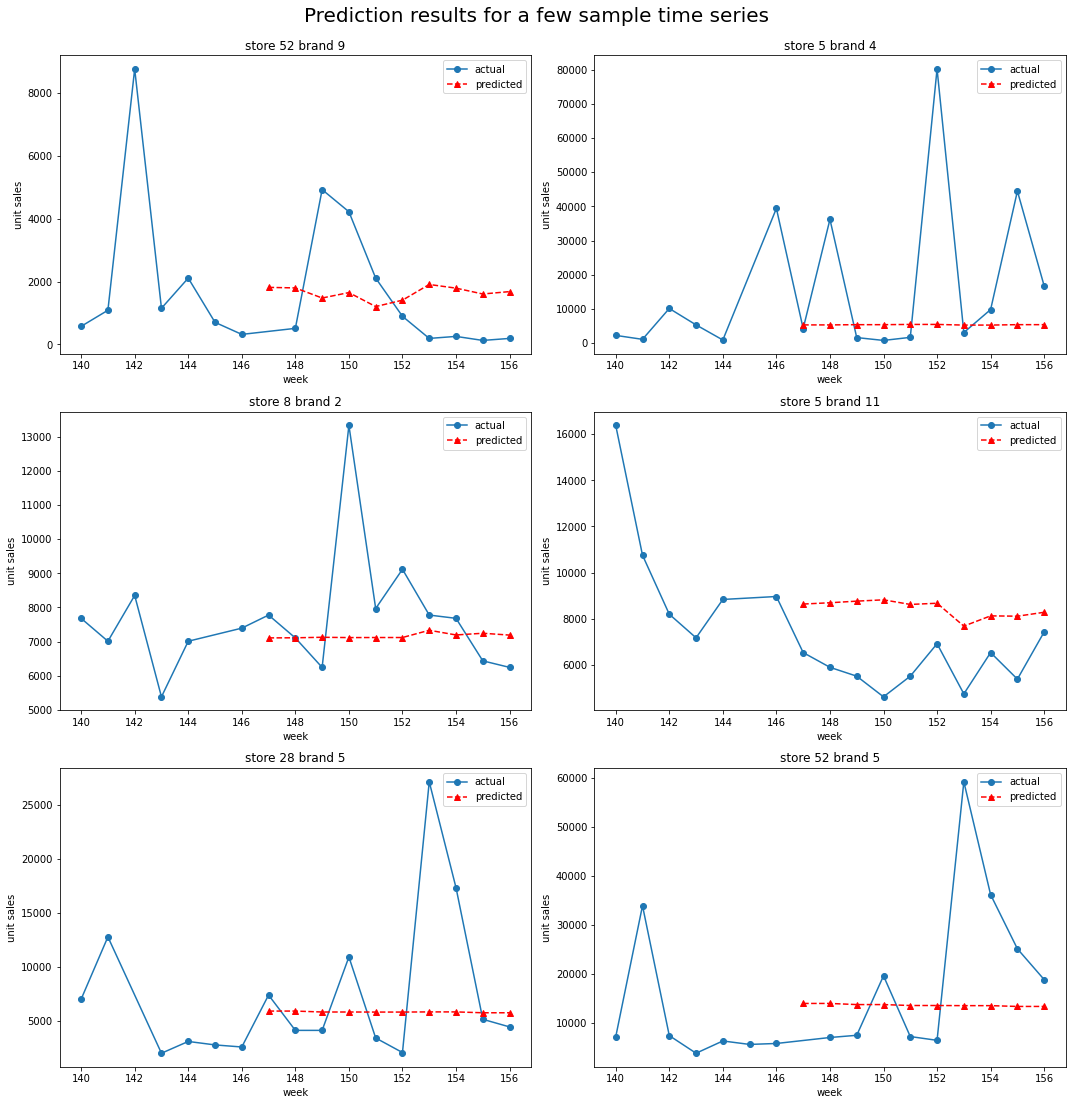

In [9]:
num_samples = 6
min_week = 140
sales = pd.read_csv(os.path.join(DATA_DIR, "yx.csv"))
sales["move"] = sales.logmove.apply(lambda x: round(math.exp(x)) if x > 0 else 0)

result_df["move"] = result_df.predictions
plot_predictions_with_history(
    result_df,
    sales,
    grain1_unique_vals=store_list,
    grain2_unique_vals=brand_list,
    time_col_name="week",
    target_col_name="move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=min_week,
    num_samples=num_samples,
    predict_at_timestep=145,
    line_at_predict_time=False,
    title="Prediction results for a few sample time series",
    x_label="week",
    y_label="unit sales",
    random_seed=2,
)

## Additional Reading

\[1\] Rob J Hyndman and George Athanasopoulos. 2018. Forecasting: Principles and Practice. Chapter 8 ARIMA models: https://otexts.com/fpp2/arima.html <br>

\[2\] Modern Parallel and Distributed Python: A Quick Tutorial on Ray: https://rise.cs.berkeley.edu/blog/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray/ <br>